In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import trange
import torch.nn as nn

from cloudmanufacturing.data import read_fatahi_dataset
from cloudmanufacturing.graph import dglgraph, graph_gamma, os_type, so_type, ss_type
from cloudmanufacturing.graphconv import GNN
from cloudmanufacturing.solvers.mip_solver import mip_solve
from cloudmanufacturing.validation import construct_delta, objvalue

In [2]:
dataset = read_fatahi_dataset("../data/fatahi.xlsx")
len(dataset)

  0%|          | 0/18 [00:00<?, ?it/s]

18

In [3]:
train_problem = dataset[0]
test_problem = dataset[2]
train_problem["name"], test_problem["name"]

('5,10,10-1', '5,10,10-3')

In [4]:
# train_delta, train_gamma, status, value = mip_solve(train_problem)
# print(f'Problem {train_problem["name"]}: {value:.2f}, {status}')

# np.save('gamma_0.npy', train_gamma)
# np.save('delta_0.npy', train_delta)

train_gamma = np.load('gamma_0.npy')
train_delta = np.load('delta_0.npy')

In [5]:
# test_delta, test_gamma, status, value = mip_solve(test_problem)
# print(f'Problem {test_problem["name"]}: {value:.2f}, {status}')

# np.save('gamma_1.npy', test_gamma)
# np.save('delta_1.npy', test_delta)

test_gamma = np.load('gamma_1.npy')
test_delta = np.load('delta_1.npy')

In [6]:
train_graph = dglgraph(train_problem, train_gamma, train_delta)
train_target = train_graph.edata["target"][os_type]
train_graph.edata["feat"][os_type][:, 0] /= 10
train_graph.edata["feat"][ss_type][:] /= 100

test_graph = dglgraph(test_problem, test_gamma, test_delta)
test_target = test_graph.edata["target"][os_type]
test_graph.edata["feat"][os_type][:, 0] /= 10
test_graph.edata["feat"][ss_type][:] /= 100

In [28]:
train_target

tensor([10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  4.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  

In [35]:
np.argmax(F.softmax(logits, dim=-1).detach().numpy(), axis=1)

array([ 0,  0,  0,  0,  0,  0,  0,  7,  7,  7,  7,  7,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  7,  0,  0,  0,  0,
        0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        1,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  1,  0,  0,  0,
        0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0, 10,  0, 10,  0,  0,  0,
       10,  0,  7,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  7,  7,  7,
        7,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [33]:
model = GNN(1,
            train_problem["n_suboperations"] + 2,
            12,
            1)

train_loss = []
test_loss = []
train_objvalue = []
test_objvalue = []

optim = Adam(model.parameters(), lr=0.0005)
weights = torch.tensor([0.2]+[1 for i in range(11)])
criterion = nn.CrossEntropyLoss(weight=weights)
for i in trange(302):
    logits = model(train_graph)
    loss = criterion(logits, train_target.long())
    optim.zero_grad()
    loss.backward()
    optim.step()

    if i % 10 == 0:
        with torch.no_grad():
            train_loss.append(loss.item())
            pred_gamma_train = model.predict(train_graph, train_problem)
            train_objvalue.append(
                objvalue(
                    train_problem,
                    pred_gamma_train,
                    construct_delta(train_problem, pred_gamma_train),
                )
            )
            logits = model(test_graph)
            loss = criterion(logits, test_target.long())
            test_loss.append(loss.item())
            pred_gamma_test = model.predict(test_graph, test_problem)
            test_objvalue.append(
                objvalue(
                    test_problem, pred_gamma_test, construct_delta(test_problem, pred_gamma_test)
                )
            )

  0%|          | 0/302 [00:00<?, ?it/s]

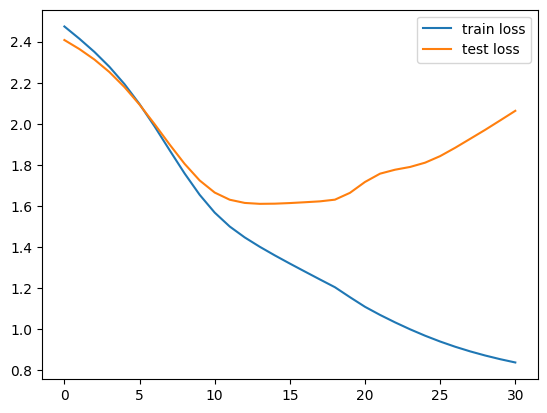

In [34]:
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")
plt.legend()
plt.show()

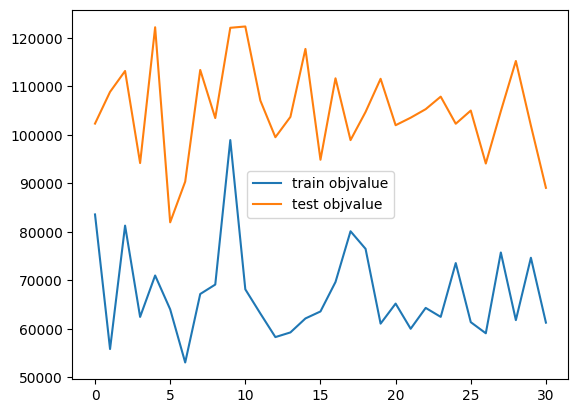

In [36]:
plt.plot(train_objvalue, label="train objvalue")
plt.plot(test_objvalue, label="test objvalue")
plt.legend()
plt.show()

In [13]:
min(test_objvalue)

33927.213390050485

## Delta constructing demonstration

In [14]:
graph = train_graph
gamma = graph_gamma(graph, train_problem)

Our target:

In [24]:
graph.edata["target"][os_type]

tensor([11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  5.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  0., 11.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [23]:
train_delta[:,3,0,5,0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [54]:
# Non zero target mask
target_mask = graph.edata["target"][os_type] != 0
# take only non zero targets
apl_targ = graph.edata["target"][os_type][target_mask]
# Operations matrix
operations = train_problem['operations']
# Return source and destination nodes from graph
u, v = graph.edges(
    etype=os_type,
)
# Mask applying
u, v = u[target_mask], v[target_mask]

# Create future delta
new_delta = np.zeros((train_problem['n_services'], train_problem['n_cities'], train_problem['n_cities'],
                      train_problem['n_suboperations'], train_problem['n_operations']))

# Demonstration how it works:
# Iterate through all operation index based on source (operations) nodes
for i,(operation, sub_op) in enumerate(graph.ndata["operation_index"]["o"][u]):
        if i != 0:
            sub_op = sub_op.item()
            operation = operation.item()
            # print the initial point:
            prev_sub_op = graph.ndata["operation_index"]["o"][u][i-1][1].item()
            prev_city = v[i-1].item()
            cur_city = v[i].item()
            print('Init gamma', train_gamma[prev_sub_op, operation,:])
            print(f'The the initial point: op-{operation}, supob-{prev_sub_op}, city-{prev_city} \n')

            # Print the next point:
            print('Cur Gamma', train_gamma[sub_op, operation, :])
            print(f'The the next point: op-{operation}, supob-{sub_op}, city-{cur_city} \n')

            # Print the current target value
            print('Current value target ', apl_targ[i-1].item())
            print('Current company ', apl_targ[i-1].item()-1)
            
            print('Delta', train_delta[:, prev_city, cur_city, sub_op, operation])
            print('------------------------------------------------ \n \n ')
            new_delta[int(apl_targ[i-1]-2),
                        v[i-1],
                        v[i],
                        sub_op,
                        operation] = 1

Init gamma [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The the initial point: op-0, supob-2, city-0 

Cur Gamma [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
The the next point: op-0, supob-4, city-3 

Current value target  11.0
Current company  10.0
Delta [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
------------------------------------------------ 
 
 
Init gamma [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
The the initial point: op-0, supob-4, city-3 

Cur Gamma [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The the next point: op-0, supob-5, city-0 

Current value target  8.0
Current company  7.0
Delta [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
------------------------------------------------ 
 
 
Init gamma [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The the initial point: op-0, supob-5, city-0 

Cur Gamma [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
The the next point: op-0, supob-6, city-7 

Current value target  2.0
Current company  1.0
Delta [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
------------------------------------------------ 
 
 
Init gamma [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
The the in

## Restoring delta using gamma

In [60]:
recons_delta = construct_delta(train_problem, pred_gamma_train)

In [81]:
pred_gamma_train[:, 4]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [76]:

np.where(pred_gamma_train[:, 0] > 0)

(array([2, 4, 5, 6, 7]), array([0, 3, 0, 7, 0]))

In [71]:
recons_delta[:,0,3,4,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])